# Data Dimensionality Reduction
Comparar os 4 métodos de redução de dimensões (PCA, SVD, NMF e Autoencoder) em relação ao modelo sem nenhum tipo de redução.  
Para tornar o exercício mais interessante, será avaliado não só os 4 algoritmos de redução de dimensão, mas também vários modelos de classificação.  
O objetivo final é termos a melhor opção entre o modelo de classificação e de redução (se for o caso).  

### Base de dados - SK-Learn Breast Cancer

Para o exercício será utilizado o dataset do sklearn **breast cancer** (UCI ML Breast Cancer) no que contém informações sobre câncer de mama e a classificação se é benigno ou maligno.  
Maiores detalhes sobre o dataset disponível em  
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer


***Fonte original do dataset***  
The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is downloaded from:  
https://goo.gl/U2Uwz2


## Importando o Dataset
O conjunto de dados utilizado contém possui em seu target uma classificação binária do câncer em 'malignant', 'benign' (maligno ou benigno).  
O objetivo, é criar um classificador que ao avaliar suas 30 features possa determinar o tipo do cancer.


In [25]:
#importando o conjunto de dados
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

### Exibindo as Features e targets

In [26]:

print('Target:', data.target_names, '\n')
print('Features:',data.feature_names)

Target: ['malignant' 'benign'] 

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Importando as demais bibliotecas utilizadas

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection 
plt.style.use('ggplot')

### Separando os dados em treino e teste

Para o exemplo utilizaremos uma base de tete de 30% do conjunto de dados.

In [44]:
random_state = 42
#Carregndo novamente já seprando os dados
X, y = load_breast_cancer(return_X_y=True)
#separando em treino e teste com 40% para o teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Definindo os modelos que serão utilizados 

Em princípio faremos testes com 5 tipos declassificadores

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#import warnings
#from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings("ignore",  category = ConvergenceWarning)

def rodar_modelo(models):
    '''Executa os modelos definidos (parametros default) e retorna o modelo com melhor performance'''
    results = []
    names = []
    scoring = 'accuracy'
    print('Resultado da avaiação')
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=random_state, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results.mean())
        names.append(name)
        msg = "  %s: media %f (dp %f - max %f)" % (name, cv_results.mean(), cv_results.std(), cv_results.max())
        print(msg)
    pos_melhor_modelo = results.index(max(results))
    return models[pos_melhor_modelo]


models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

melhor_modelo = rodar_modelo(models)
print('')
print('Melhor modelo:', melhor_modelo[1])

Resultado da avaiação
  KNN: media 0.904652 (dp 0.021385 - max 0.936709)
  DTC: media 0.922247 (dp 0.028700 - max 0.949367)
  GB: media 0.942310 (dp 0.018549 - max 0.974684)
  SVM: media 0.897057 (dp 0.025270 - max 0.924051)
  RF: media 0.954873 (dp 0.020186 - max 0.974684)

Melhor modelo: RandomForestClassifier()


### Aprimorando o modelo selecionado 'Random Forest Classifier'

Utilizar o GridSearch para testar um conjunto de hipoteses de parametros. O objetivo é descobrir a melhor combinação entre eles e maximizar o resultado da classificação.

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'random_state': [None, 0, 1, 2, 3, 42],
            'max_depth': [None, 1, 2, 3, 4, 15, 20],
            'n_estimators': [5, 10, 100, 150, 200], 
            'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3],
            'criterion': ['gini', 'entropy'],
            'min_samples_split': [2, 4, 6],
            'min_samples_leaf': [1, 3, 4, 5]
        },
        cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

RandomForestClassifier GIRD
  criterion :  entropy
  max_depth :  15
  max_features :  1
  min_samples_leaf :  1
  min_samples_split :  2
  n_estimators :  10
  random_state :  None

              precision    recall  f1-score   support

     Maligno       0.89      0.99      0.93        80
     Benigno       0.99      0.93      0.96       148

    accuracy                           0.95       228
   macro avg       0.94      0.96      0.95       228
weighted avg       0.96      0.95      0.95       228



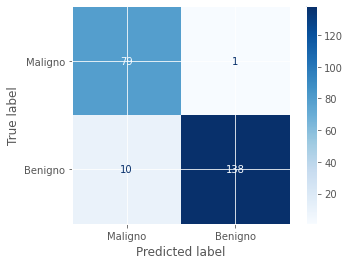

In [42]:
classifier = RandomForestClassifier(max_depth=best_params["max_depth"], 
                                    random_state=best_params["random_state"],
                                    n_estimators = best_params["n_estimators"], 
                                    max_features = best_params["max_features"],
                                    criterion=best_params["criterion"], 
                                    min_samples_split=best_params["min_samples_split"], 
                                    min_samples_leaf = best_params["min_samples_leaf"])

results = []
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador

print("RandomForestClassifier GIRD")
for k, v in best_params.items():
    print(' ', k, ': ',  v,)
print("")
print(classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno']))
report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('Modelo', report))
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Avaliando as features do modelo quanto a sua importancia

mean radius: 0.02827
mean texture: 0.02015
mean perimeter: 0.03507
mean area: 0.03246
mean smoothness: 0.00860
mean compactness: 0.00366
mean concavity: 0.03198
mean concave points: 0.11422
mean symmetry: 0.00480
mean fractal dimension: 0.00409
radius error: 0.02162
texture error: 0.00576
perimeter error: 0.01477
area error: 0.02925
smoothness error: 0.00631
compactness error: 0.00575
concavity error: 0.00511
concave points error: 0.00514
symmetry error: 0.00343
fractal dimension error: 0.00496
worst radius: 0.14111
worst texture: 0.01610
worst perimeter: 0.08844
worst area: 0.09414
worst smoothness: 0.01069
worst compactness: 0.01407
worst concavity: 0.05057
worst concave points: 0.17508
worst symmetry: 0.01811
worst fractal dimension: 0.00629


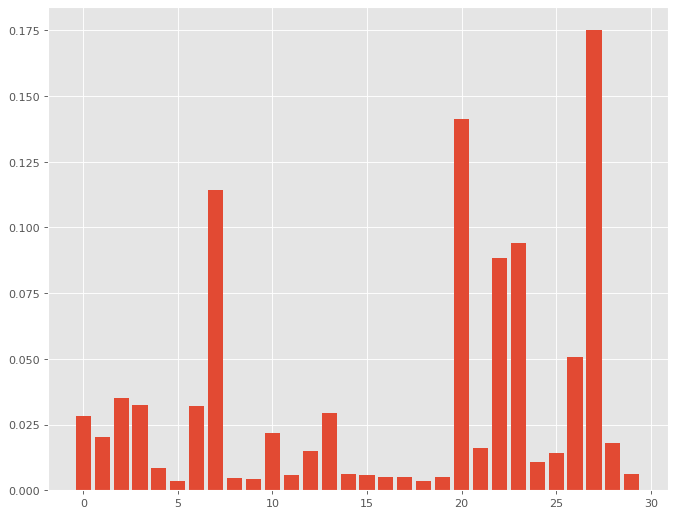

In [33]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

def avaliar_features(melhor_modelo):
    limit = 0.04
    model = melhor_modelo[1]
    model.fit(X_train, y_train)
    importance = model.feature_importances_
    colunas = data.feature_names
    top_feature = []
    # summarize feature importance
    for i,v in enumerate(importance):
        print('%s: %.5f' % (colunas[i],v))
        if (v >= limit):
            top_feature.append((i, v))

    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    return top_feature

top_feature = avaliar_features(melhor_modelo)
n_dimensions = len(top_feature)

In [34]:
print('Numero de dimensões igual ou maior que 4%:', n_dimensions)


Numero de dimensões igual ou maior que 4%: 6


## Aplicando os algoritmos de redução de dimensões para comparar os resultados

Com base no gráfico, utilizaremos o número de features que possuem uma relevancia acima de 4% (arbitrário) mas estas não serão escolhidas manualmente, apenas a recomendação do número de dimensões (número de features que possuem +4 de relevancia).

### PCA - Principal Component Analysis

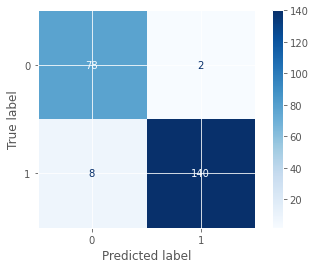

In [46]:
#Aplicar a redução de dimensão em X e rodar o processo novamente com os melhores parametros
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=n_dimensions)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador

report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('PCA', report))
classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'])
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues")
plt.show()

### SVD - Single Value Decomposition

In [45]:
#Aplicar a redução de dimensão em X e rodar o processo novamente com os melhores parametros
from sklearn.decomposition import SVD as sklearnSVD
pca = sklearnPCA(n_components=n_dimensions)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador
classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'])
report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('SVD', report))
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues")

ImportError: cannot import name 'SVD' from 'sklearn.decomposition' (C:\Users\saccacio\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\__init__.py)

### NMF - Non-negative Matrix Factorization

In [ ]:
from sklearn.decomposition import NMF as sklearnNMF
pca = sklearnPCA(n_components=n_dimensions)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador
classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'])
report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('NMF', report))
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues")

### Autoencoder

In [74]:
## Import do keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers




array([0, 1, 2, 3])

### Comparando os resultados

['Modelo', 'PCA']

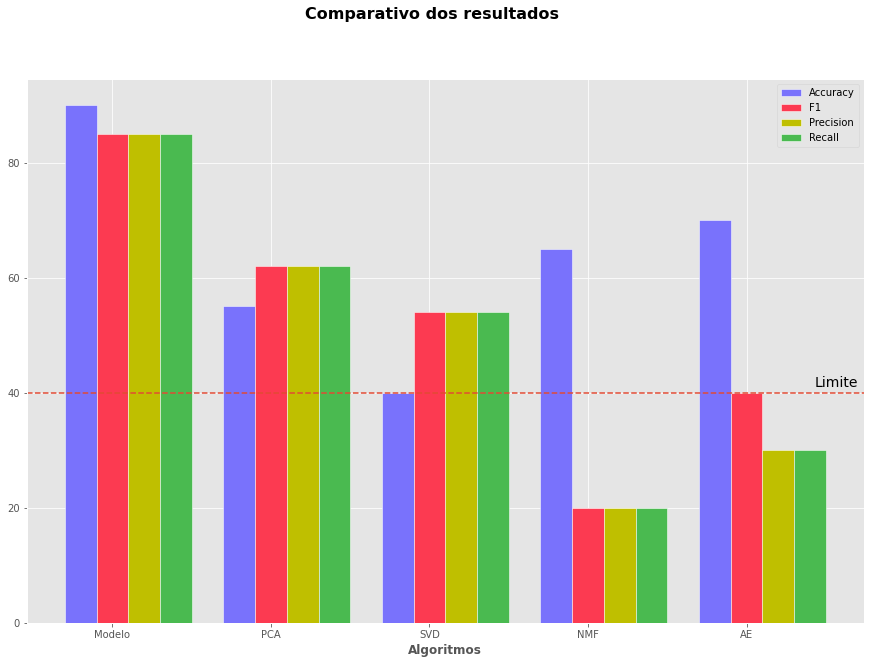

In [150]:
import numpy as np
import matplotlib.pyplot as plt

#report
#macro_precision =  results[0]['macro avg']['precision'] 
#macro_recall = report['macro avg']['recall']    
#macro_f1 = report['macro avg']['f1-score']
#accuracy = report['accuracy']

import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.20

# data to plot
acc = [90, 55, 40, 65, 70]
f1 = [85, 62, 54, 20, 40]
precision = [85, 62, 54, 20, 30]
recall = [85, 62, 54, 20, 30]


# Set position of bar on X axis
r1 = np.arange(len(acc))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparativo dos resultados', fontsize=16, fontweight='bold')

#make the plot
plt.bar(r1, acc, color='#7972fc', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, f1, color='#fc3a51', width=barWidth, edgecolor='white', label='F1')
plt.bar(r3, precision, color='y', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, recall, color='#4aba50', width=barWidth, edgecolor='white', label='Recall')

# Add xticks on the middle of the group bars
plt.xlabel('Algoritmos', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(acc))], ['Modelo', 'PCA', 'SVD', 'NMF', 'AE'])

plt.axhline(y=40, linestyle="--")
plt.annotate("Limite", xy=(4, 41), xycoords='data', xytext=(100, 0), textcoords='offset points', fontsize=14)
 
# Create legend & Show graphicacc
plt.legend()
plt.show()